In [19]:
import json
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import sys
import re
from wordcloud import WordCloud
from datetime import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
import math

## python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2 * 10**6

SIA = SentimentIntensityAnalyzer()

with open("kaggle.json", "r") as f:
    KAGGLE_CREDENTIALS = json.load(f)
FILE_NAME = "covid19_articles_20201231.csv"

os.environ["KAGGLE_USERNAME"] = KAGGLE_CREDENTIALS["username"]
os.environ["KAGGLE_KEY"] = KAGGLE_CREDENTIALS["key"]

api = KaggleApi()
api.authenticate()


In [3]:
dataset = api.dataset_download_file(
    "jannalipenkova/covid19-public-media-dataset", FILE_NAME
)

with zipfile.ZipFile(FILE_NAME + ".zip", "r") as zip_ref:
    zip_ref.extractall("data")

os.remove(FILE_NAME + ".zip")


2022-02-22 22:24:57,440 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x113db0a00>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')': /api/v1/datasets/download/jannalipenkova/covid19-public-media-dataset/covid19_articles_20201231.csv
2022-02-22 22:24:57,442 WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x113da0b50>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')': /api/v1/datasets/download/jannalipenkova/covid19-public-media-dataset/covid19_articles_20201231.csv
2022-02-22 22:24:57,443 WARNING Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.

MaxRetryError: HTTPSConnectionPool(host='www.kaggle.com', port=443): Max retries exceeded with url: /api/v1/datasets/download/jannalipenkova/covid19-public-media-dataset/covid19_articles_20201231.csv (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x113db06d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [4]:
df = pd.read_csv("data/" + FILE_NAME)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


In [5]:
print(len(df))
for col in df:
    print(col, end=" ")
    print(len(df[col].unique()))


369047
author 30700
date 363
domain 66
title 354320
url 364827
content 368920
topic_area 11


In [6]:
df.tail()

,author,date,domain,title,url,content,topic_area
369042,Polly Harrison,2020-12-31,thefintechtimes,A Human Touch Will Be a Competitive Edge After...,https://thefintechtimes.com/53867-2/,Niels Pedersen is a Chartered Accountant and S...,finance
369043,NaN,2020-12-31,marketscreener,Datametrex AI : Announces Deploying NexaSecuri...,https://www.marketscreener.com/quote/stock/DAT...,Datametrex AI Limited (TSXV: DM) (FSE: D4G) (O...,business
369044,Polly Harrison,2020-12-31,thefintechtimes,"US Payments: Smart Pension, Episode Six, PAAY ...",https://thefintechtimes.com/us-payments-smart-...,"This December, The Fintech Times is asking ind...",finance
369045,NaN,2020-12-31,marketscreener,"WESTWATER RESOURCES, INC. : Entry into a Mater...",https://www.marketscreener.com/quote/stock/WES...,Item 1.01Entry into a Material Definitive Agre...,business
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business


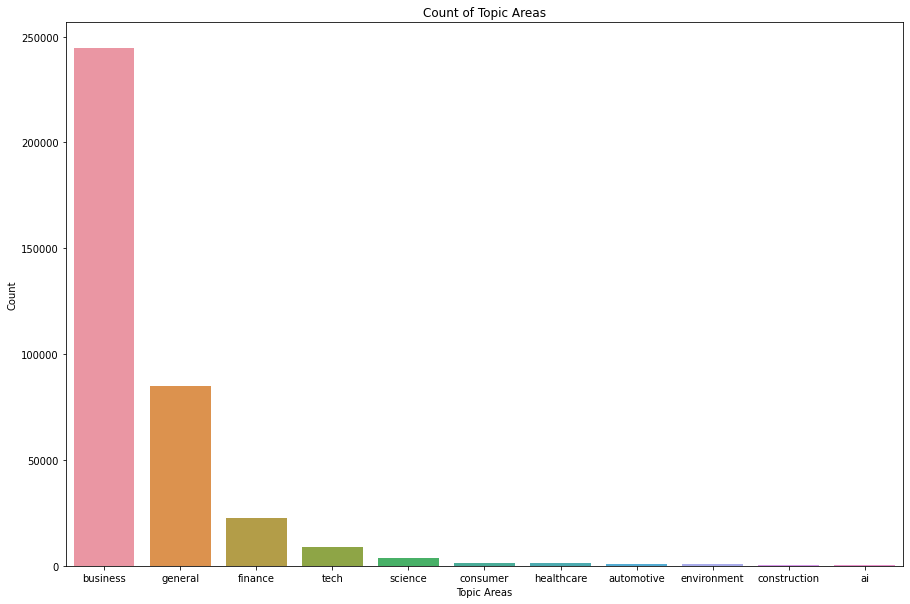

In [7]:
## Actual topic distribution
plt.figure(figsize=(15, 10))
sns.barplot(x=y.value_counts().index, y=y.value_counts())
plt.xlabel("Topic Areas")
plt.ylabel("Count")
plt.title("Count of Topic Areas")
plt.show()

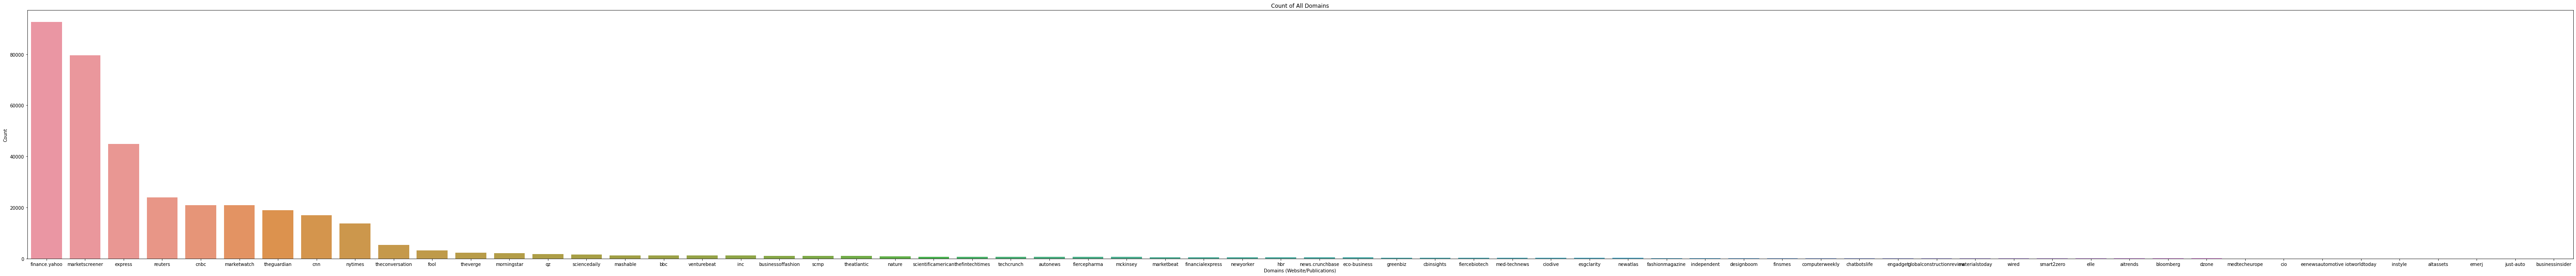

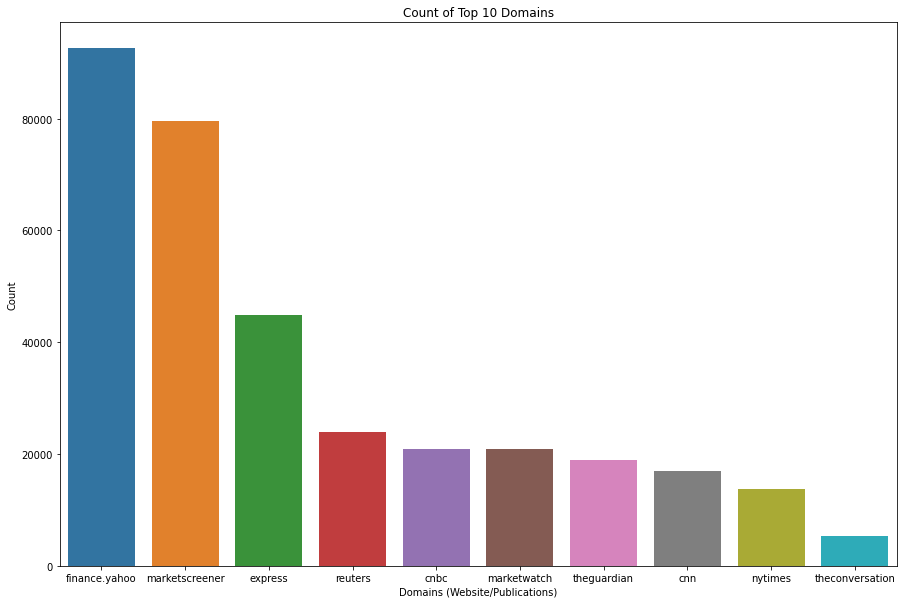

In [8]:
## domain distribution
plt.figure(figsize=(100, 10))
sns.barplot(x=df.domain.value_counts().index, y=df.domain.value_counts())
plt.xlabel("Domains (Website/Publications)")
plt.ylabel("Count")
plt.title("Count of All Domains")
plt.show()

domain_counts = df.domain.value_counts().to_dict()
top_10_domain = {
    x: domain_counts[x]
    for x in heapq.nlargest(10, domain_counts, key=domain_counts.get)
}
plt.figure(figsize=(15, 10))
sns.barplot(x=list(top_10_domain.keys()), y=list(top_10_domain.values()))
plt.xlabel("Domains (Website/Publications)")
plt.ylabel("Count")
plt.title("Count of Top 10 Domains")
plt.show()


In [9]:
## Word cloud
if os.path.isfile("./unique_words_count.json"):
    with open("unique_words_count.json", "r") as f:
        unique_words_count = json.load(f)
else:
    stopwords = nlp.Defaults.stop_words
    unique_words_count = {}
    for i, row in df.iterrows():
        # sys.stdout.write(str(i) + "\r")
        # sys.stdout.flush()
        tokens = row.content.lower().split(" ")
        for t in tokens:
            if t not in stopwords:
                unique_words_count[t] = unique_words_count.get(t, 0) + 1

top_100_unique_words = {
    x: unique_words_count[x]
    for x in heapq.nlargest(100, unique_words_count, unique_words_count.get)
    if re.match(r"^[a-z]*$", x) and x != ""
}


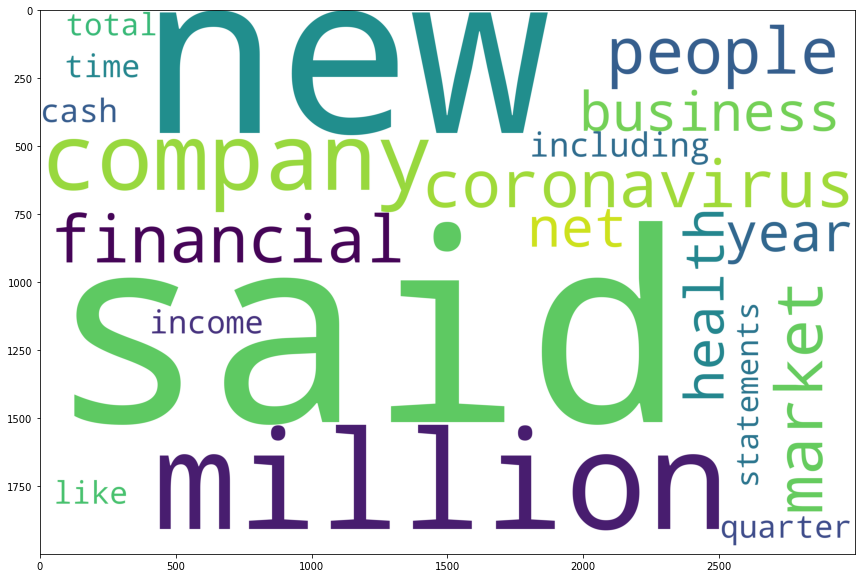

In [10]:
wc = WordCloud(
    background_color="white",
    width=3000,
    height=2000,
    max_words=20,
    relative_scaling=0.5,
    normalize_plurals=False,
).generate_from_frequencies(top_100_unique_words)
plt.figure(figsize=(15,10))
plt.imshow(wc)


In [11]:
len([x for x in unique_words_count if re.match(r"^[a-z]*$", x) and x != ""])


462302

In [12]:
## By date
df.date.value_counts()

2020-07-28    3967
2020-07-29    3883
2020-07-23    3830
2020-07-21    3757
2020-07-16    3467
              ... 
2020-01-03       3
2020-01-11       1
2020-01-10       1
2020-01-12       1
2020-01-02       1
Name: date, Length: 363, dtype: int64

In [13]:
# df.date = pd.to_datetime(df.date, format="%Y-%m-%d")
# plt.figure(figsize=(15,10))
# df["date"].groupby(by=[df.date.dt.month, df.date.dt.year]).value_counts()
month_counts = {}
for i, row in df.iterrows():
    # sys.stdout.write(str(i) + "\r")
    date_string = datetime.strftime(datetime.strptime(row.date, "%Y-%m-%d"), "%B-%Y")
    month_counts[date_string] = month_counts.get(date_string, 0) + 1
    # sys.stdout.flush()


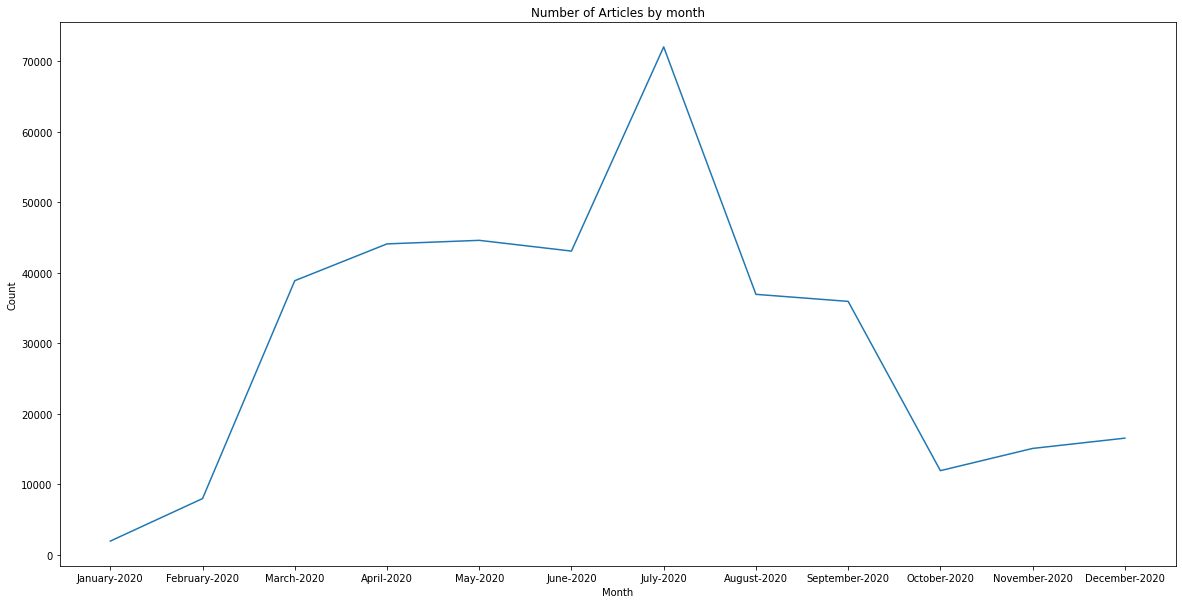

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(list(month_counts.keys()), list(month_counts.values()))
plt.title("Number of Articles by month")
plt.ylabel("Count")
plt.xlabel("Month")
plt.show()


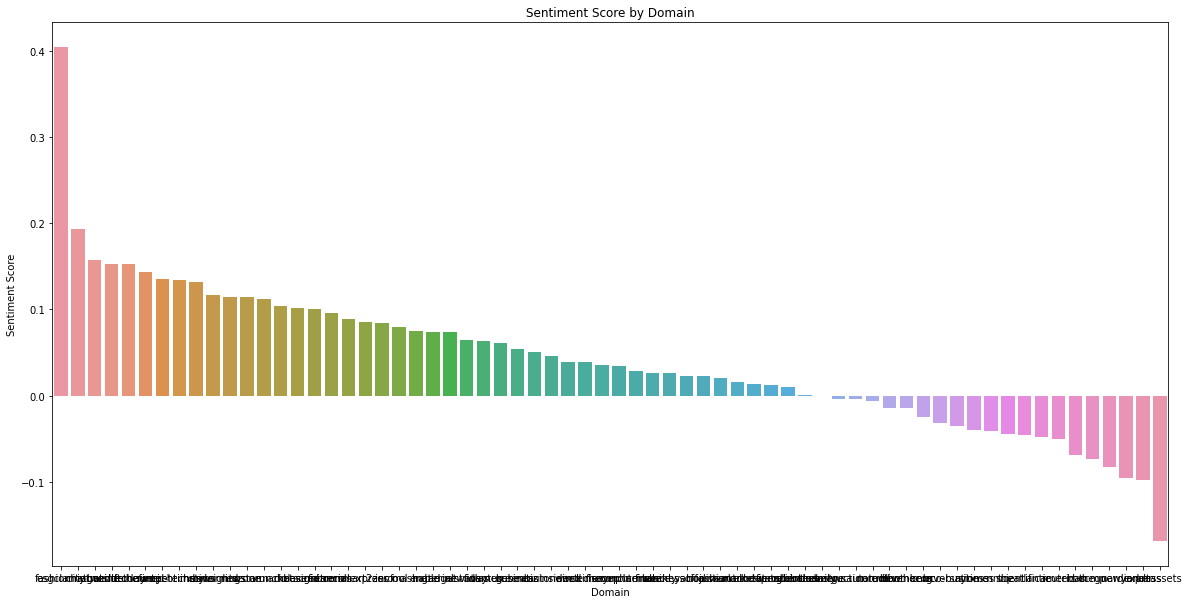

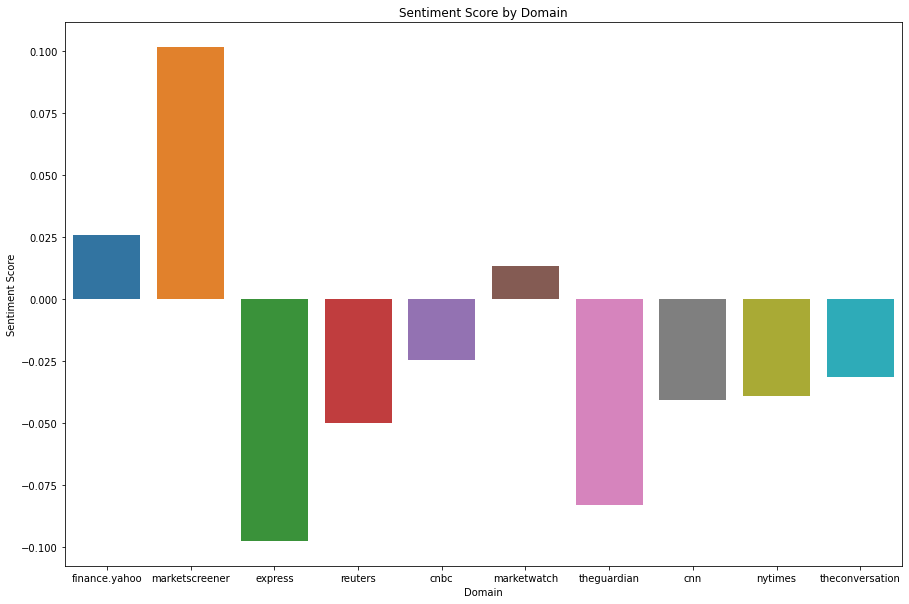

In [15]:
## Sentiment analysis on title
if os.path.isfile("./domain_title_sentiment.json"):
    with open("domain_title_sentiment.json", "r") as f:
        domain_title_sentiment = json.load(f)
else:
    domain_title_sentiment = {}
    for i, row in df.iterrows():
        if isinstance(row.title, str):
            sentiment_score = SIA.polarity_scores(row.title)["compound"]
            arr = domain_title_sentiment.get(row.domain, [])
            arr.append(sentiment_score)
            domain_title_sentiment[row.domain] = arr
    domain_title_sentiment = {
        k: sum(v) / len(v) for k, v in domain_title_sentiment.items()
    }
    domain_title_sentiment = {
        x: domain_title_sentiment[x]
        for x in heapq.nlargest(
            len(domain_title_sentiment),
            domain_title_sentiment,
            key=domain_title_sentiment.get,
        )
    }

plt.figure(figsize=(20, 10))
sns.barplot(
    x=list(domain_title_sentiment.keys()), y=list(domain_title_sentiment.values())
)
plt.xlabel("Domain")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Score by Domain")
plt.show()

plt.figure(figsize=(15, 10))
sns.barplot(
    x=list(top_10_domain.keys()),
    y=[domain_title_sentiment[x] for x in list(top_10_domain.keys())],
)
plt.xlabel("Domain")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Score by Domain")
plt.show()


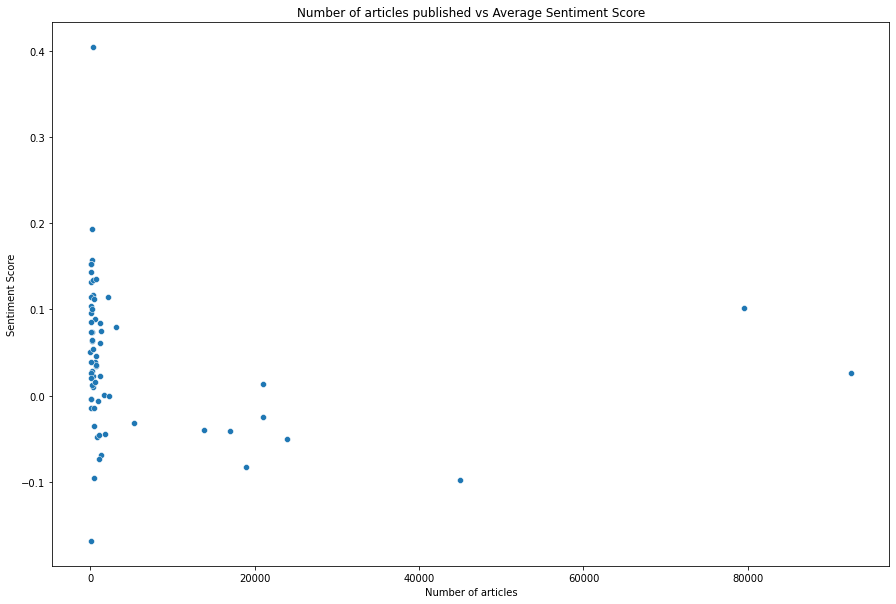

In [21]:
_domains = sorted(domain_counts)
plt.figure(figsize=(15, 10))
sns.scatterplot(
    y=[domain_title_sentiment[x] for x in _domains],
    x=[domain_counts[x] for x in _domains],
)
plt.xlabel("Number of articles")
plt.ylabel("Sentiment Score")
plt.title("Number of articles published vs Average Sentiment Score")
plt.show()


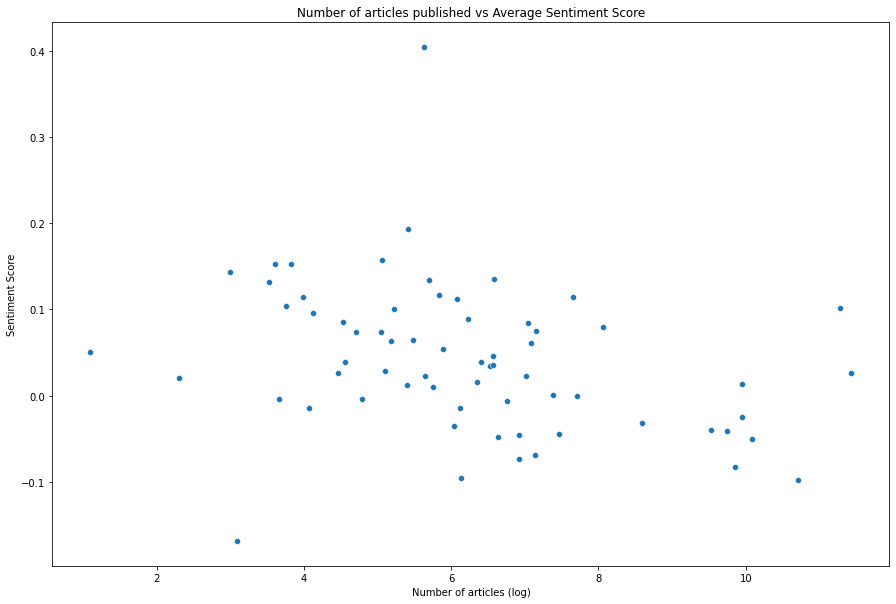

In [23]:
plt.figure(figsize=(15, 10))
sns.scatterplot(
    y=[domain_title_sentiment[x] for x in _domains],
    x=[math.log(domain_counts[x]) for x in _domains],
)
plt.xlabel("Number of articles (log)")
plt.ylabel("Sentiment Score")
plt.title("Number of articles published vs Average Sentiment Score")
plt.show()

In [24]:
math.log(800000)

13.592367006650065

In [26]:
math.log(100)

4.605170185988092